# Maritime Trade: MLP Baseline Models

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install and import packages
!pip install category_encoders
!pip install Tensorflow
import os
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import datetime
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
my_dpi = 96
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 156 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
TensorFlow version: 2.9.2
Eager execution is: True
Keras version: 2.9.0
Num GPUs Available: 1


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Sat Dec 10 22:45:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|        

In [ ]:
# Reproducibility in TF and Pytorch
def init_seeds(seed=101920):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=101920)

## Train 2019 Baseline Batch Size = 16

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

# Create year-week for stratification
df['DateTime']= pd.to_datetime(df['DateTime'])
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

df = df.drop(['DateTime'], axis=1)

# Filter df to 2019
df1 = df[df['Year'] == 2019]

# Filter df to 2020
df2 = df[df['Year'] == 2020]

# Drop year variable
df1 = df1.drop(['Year'], axis=1)
df2 = df2.drop(['Year'], axis=1)

# Prepare 2020 for partitioning data
X = df1.drop(['Metric_Tons'], axis=1)
y = df1['Metric_Tons']

Number of rows and columns: (6633785, 20)


In [ ]:
# Set up train/test split with stratified by 'DateTime_YearWeek'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.DateTime_YearWeek,
                                                    random_state=1920)

# Drop time variable
X_train = X_train.drop(['DateTime_YearWeek'], axis=1)
X_test = X_test.drop(['DateTime_YearWeek'], axis=1)

# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print('Dimensions of X_train for input:', X_train.shape[1])

# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

Dimensions of X_train for input: 34


In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Models/DL/MLP/Models

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

/content/drive/MyDrive/MaritimeTrade/Models/DL/MLP/Models


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train19_baseline_sc_b16_epochs30.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  best_model_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Define Baseline model
model = Sequential()
model.add(Dense(30, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
model.compile(loss='mae', metrics=['mse'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1050      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
134740/134740 [==============================] - 311s 2ms/step - loss: 11.6150 - mse: 880.4813 - val_loss: 10.0269 - val_mse: 588.8330
Epoch 2/30
134740/134740 [==============================] - 297s 2ms/step - loss: 10.3371 - mse: 564.0920 - val_loss: 9.3850 - val_mse: 499.2766
Epoch 3/30
134740/134740 [==============================] - 297s 2ms/step - loss: 10.0675 - mse: 539.0044 - val_loss: 9.1811 - val_mse: 482.0979
Epoch 4/30
134740/134740 [==============================] - 297s 2ms/step - loss: 9.9154 - mse: 526.2175 - val_loss: 8.9635 - val_mse: 450.3198
Epoch 5/30
134740/134740 [==============================] - 296s 2ms/step - loss: 9.8207 - mse: 521.3840 - val_loss: 8.7572 - val_mse: 441.7188
Epoch 6/30
134740/134740 [==============================] - 295s 2ms/step - loss: 9.7510 - mse: 515.8300 - val_loss: 8.7677 - val_mse: 432.5368
Epoch 7/30
134740/134740 [==============================] - 295s 2ms/step - loss: 9.7058 - mse: 507.7592 - val_loss: 8.9692 - val_ms

In [ ]:
# Save model
model.save('./MLP_Baseline_sc_batch16_30epochs_train19_tf.h5', save_format='tf')

# Load model for more training or later us
#filepath = 'MLP_weights_only_train19_baseline_sc_b16_epochs30.h5'
#model = tf.keras.models.load_model('./MLP_Baseline_sc_batch16_30epochs_train19_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

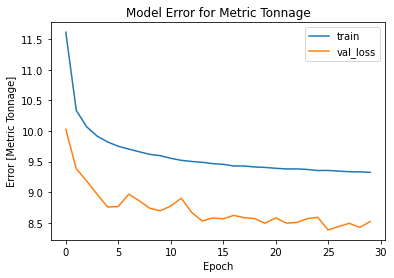

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train19_baselineSC_batch16_30Epochs_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

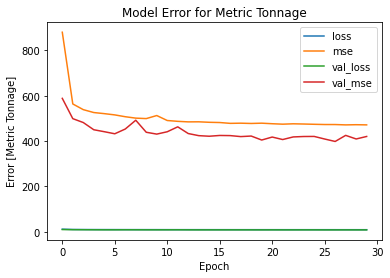

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train19_baselineSC_batch16_30Epochs_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2694793, 1)

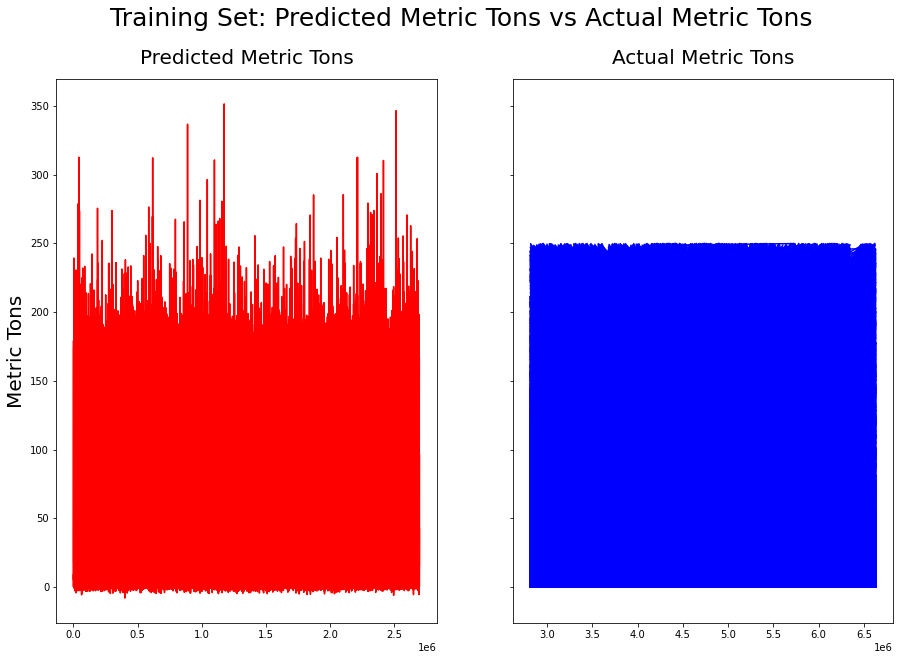

In [ ]:
# Graph predicted vs actual metric tonnage in the train set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train19_baselineSC_batch16_30Epochs_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

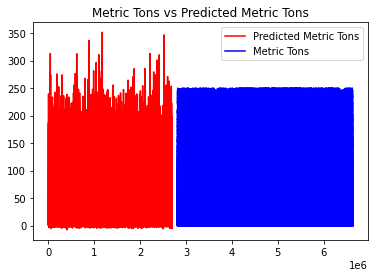

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_baselineSC_batch16_30Epochs_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(673699, 1)

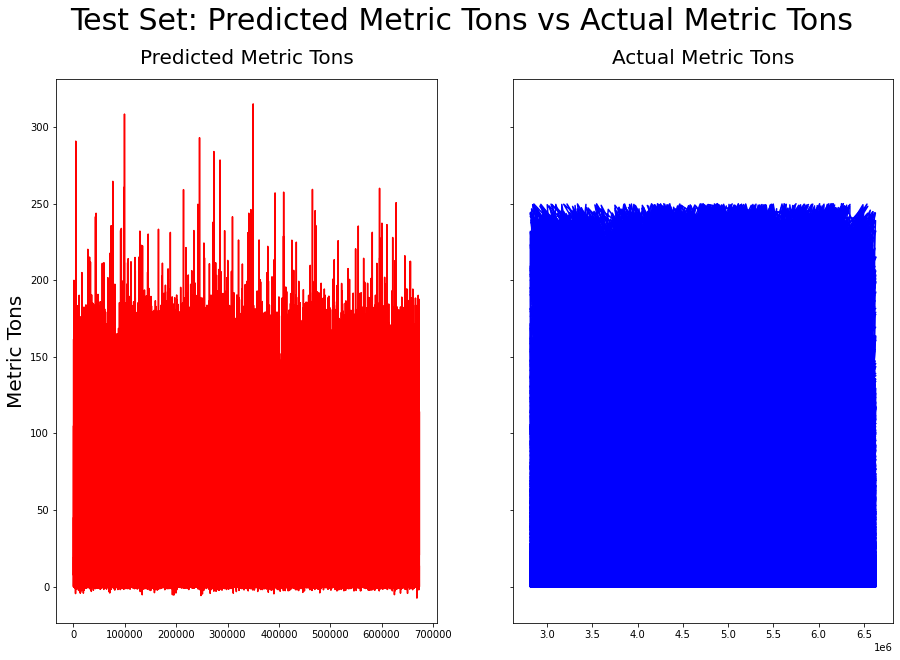

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train19_baselineSC_batch8_30Epochs_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

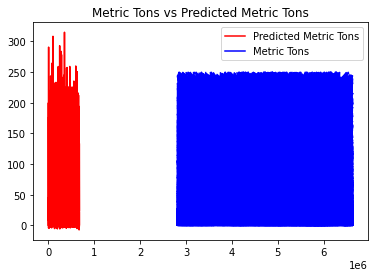

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19_baselineSC_batch16_30Epochs_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f'% np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 8.529655
MSE: 422.753801
RMSE: 20.560978
R2: 0.579966


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 9.251954
MSE: 459.566662
RMSE: 21.437506
R2: 0.543552


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons', np.average(y_test))
print('Predicted Average Metric Tons', np.average(pred_test))
print('\nMinimum Metric Tons', np.amin(y_test))
print('Predicted Minimum Metric Tons', np.amin(pred_test))

Maximum Metric Tons 249.99
Predicted Max Metric Tons: 315.0854

Average Metric Tons 21.895935662662403
Predicted Average Metric Tons 17.043827

Minimum Metric Tons 0.0
Predicted Minimum Metric Tons -7.53874


#### Test on 2020

In [ ]:
# Prepare 2019 for partitioning data
X = df2.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df2['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3265293, 1)

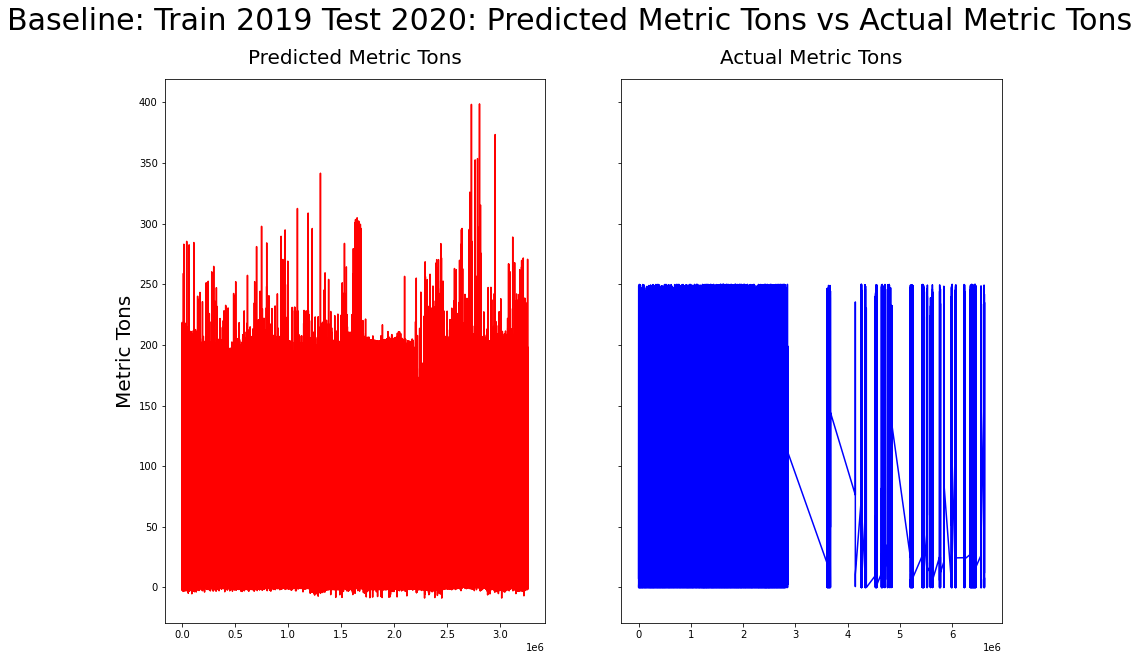

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Baseline: Train 2019 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

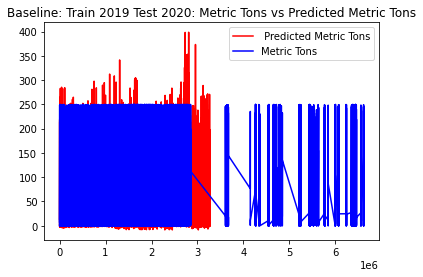

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Baseline: Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train19Test20_baselineSC_batch8_30Epochs_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 8.862149
MSE: 431.787379
RMSE: 20.779494
R2: 0.542457


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 398.72498

Average Metric Tons: 21.53519470993873
Predicted Average Metric Tons: 18.037947

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -8.755297


## Train 2020 Baseline Batch Size = 16

In [ ]:
# Prepare 2020 for partitioning data
X = df2.drop(['Metric_Tons'],axis=1)
y = df2['Metric_Tons']

# Set up train/test split with stratified by 'DateTime_YearWeek'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.DateTime_YearWeek,
                                                    random_state=1920)

# Drop time variable
X_train = X_train.drop(['DateTime_YearWeek'], axis=1)
X_test = X_test.drop(['DateTime_YearWeek'], axis=1)

# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print('Dimensions of X_train for input:', X_train.shape[1])

# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

Dimensions of X_train for input: 34


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train20_baseline_sc_b16_epochs30.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  best_model_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Define Baseline model
model = Sequential()
model.add(Dense(30, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
model.compile(loss='mae', metrics=['mse'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1050      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
130612/130612 [==============================] - 287s 2ms/step - loss: 11.3536 - mse: 697.3706 - val_loss: 9.6628 - val_mse: 495.5418
Epoch 2/30
130612/130612 [==============================] - 285s 2ms/step - loss: 10.2092 - mse: 566.1661 - val_loss: 9.3898 - val_mse: 500.8206
Epoch 3/30
130612/130612 [==============================] - 284s 2ms/step - loss: 9.9300 - mse: 520.2528 - val_loss: 9.0747 - val_mse: 461.3257
Epoch 4/30
130612/130612 [==============================] - 284s 2ms/step - loss: 9.7343 - mse: 506.4827 - val_loss: 8.8463 - val_mse: 443.3396
Epoch 5/30
130612/130612 [==============================] - 284s 2ms/step - loss: 9.6057 - mse: 491.5209 - val_loss: 8.7620 - val_mse: 431.2053
Epoch 6/30
130612/130612 [==============================] - 282s 2ms/step - loss: 9.5248 - mse: 483.6649 - val_loss: 8.8105 - val_mse: 439.9854
Epoch 7/30
130612/130612 [==============================] - 281s 2ms/step - loss: 9.4757 - mse: 480.2172 - val_loss: 8.8542 - val_mse:

In [ ]:
# Save model
model.save('./MLP_Baseline_sc_batch16_30epochs_train20_tf.h5', save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train20_baseline_sc_b16_epochs30.h5'
#model = tf.keras.models.load_model('./MLP_Baseline_sc_batch16_30epochs_train20_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

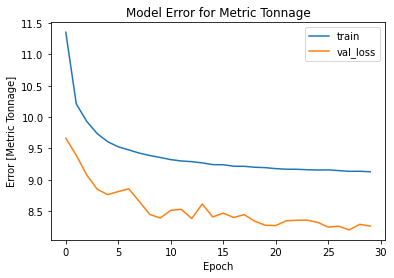

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train20_baselineSC_batch16_30Epochs_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

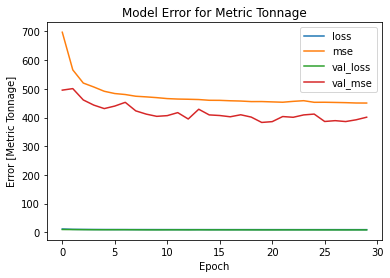

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train20_baselinSC_batch16_30Epochs_LossValLoss.png', dpi=my_dpi*10,
            bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(2612234, 1)

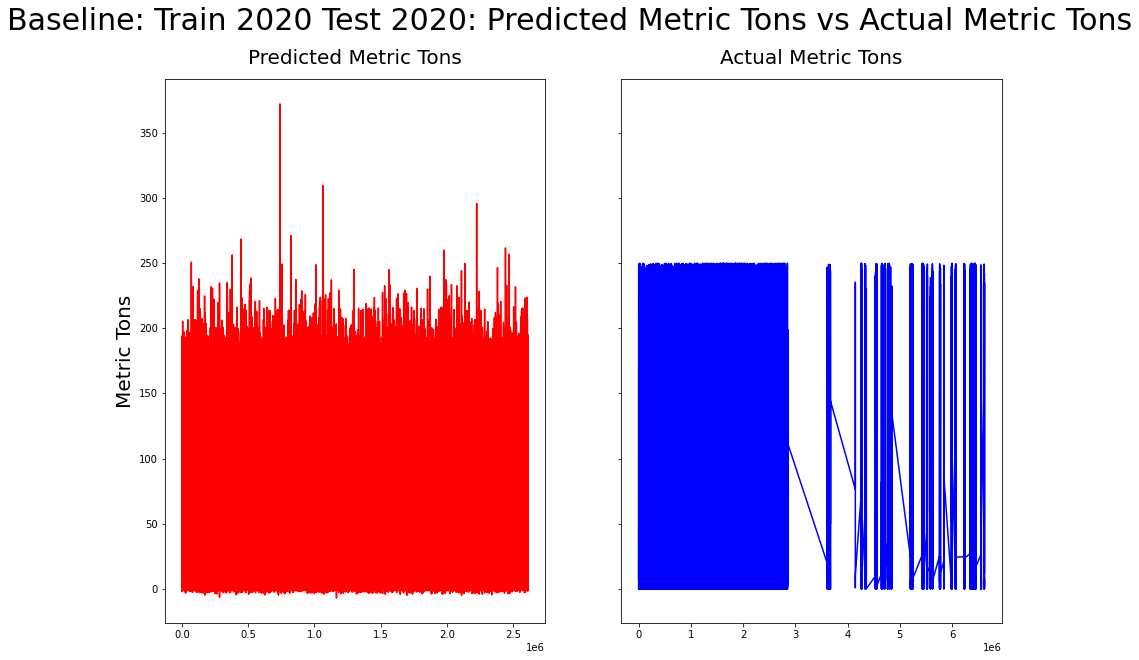

In [ ]:
# Graph predicted vs actual metric tonnage in the train set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Baseline: Train 2020 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20_baselineSC_batch16_30Epochs_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

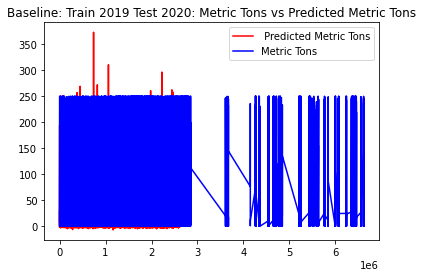

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Baseline: Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20_baselineSC_batch16_30Epochs_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(653059, 1)

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f'% np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 8.292885
MSE: 404.850157
RMSE: 20.120889
R2: 0.571114


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 8.552116
MSE: 418.956668
RMSE: 20.468431
R2: 0.555586


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons', np.average(y_test))
print('Predicted Average Metric Tons', np.average(pred_test))
print('\nMinimum Metric Tons', np.amin(y_test))
print('Predicted Minimum Metric Tons', np.amin(pred_test))

Maximum Metric Tons 249.99
Predicted Max Metric Tons: 286.75543

Average Metric Tons 21.525284239249448
Predicted Average Metric Tons 18.042938

Minimum Metric Tons 0.0
Predicted Minimum Metric Tons -6.1492796


### Test on 2019

In [ ]:
# Prepare 2019 for partitioning data
X = df1.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y = df1['Metric_Tons']

In [ ]:
# Process features
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3368492, 1)

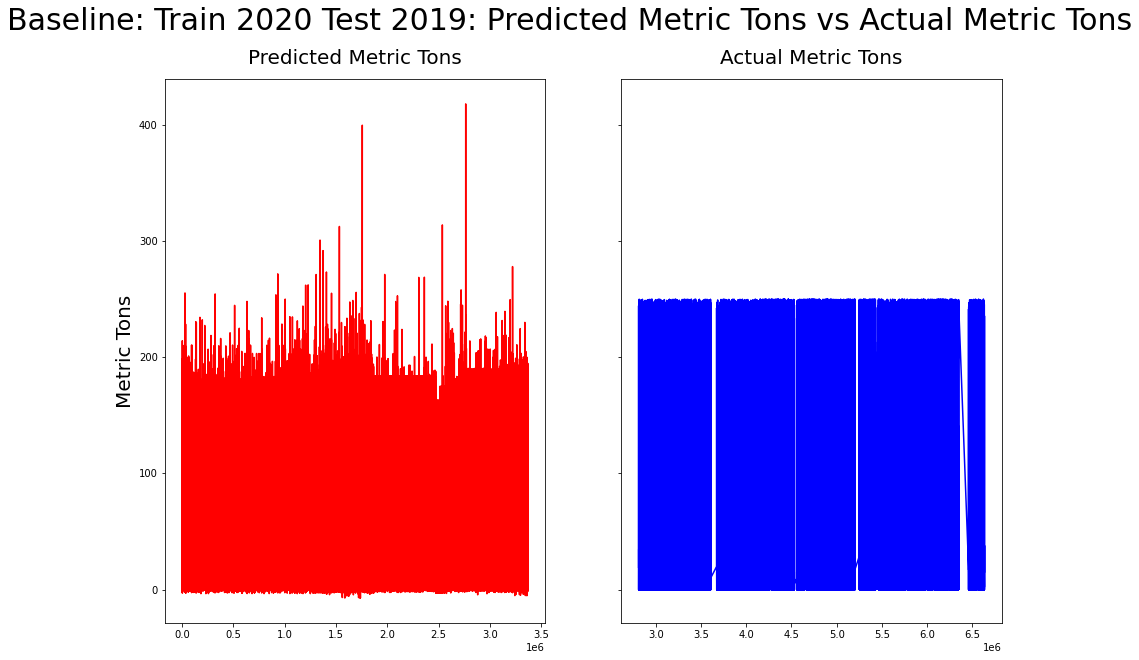

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Baseline: Train 2020 Test 2019: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train20Test19_baselineSC_batch16_30Epochs_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

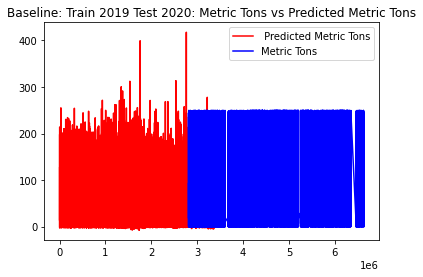

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Baseline: Train 2019 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train20Test19_baselineSC_batch16_30Epochs_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 9.556285
MSE: 516.556536
RMSE: 22.727880
R2: 0.486803


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
('\n')
print('\nAverage Metric Tons:', np.average(y))
print('Predicted Average Metric Tons:', np.average(pred_test))
('\n')
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 417.72134

Average Metric Tons: 21.897868227087965
Predicted Average Metric Tons: 17.587381

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -7.155898


## Train/Test 2019 + 2020 Baseline Batch Size = 16

In [ ]:
# X,y for encoding
X = df.drop(['Metric_Tons'], axis=1)
y = df['Metric_Tons']

del df

# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=X.Year,
                                                    random_state=1920)

# Drop year
X_train = X_train.drop(['Year'], axis=1)
X_test = X_test.drop(['Year'], axis=1)

# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print('Dimensions of X_train for input:', X_train.shape[1])

# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

Dimensions of X_train for input: 34


In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Models/DL/MLP/Models

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

/content/drive/MyDrive/MaritimeTrade/Models/DL/MLP/Models


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train1920_baseline_sc_b16_epochs30.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  best_model_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Define Baseline model
model = Sequential()
model.add(Dense(30, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
model.compile(loss='mae', metrics=['mse'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1050      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
232183/232183 [==============================] - 532s 2ms/step - loss: 10.7004 - mse: 736.9232 - val_loss: 9.5513 - val_mse: 526.7225
Epoch 2/30
232183/232183 [==============================] - 527s 2ms/step - loss: 9.8171 - mse: 515.0393 - val_loss: 8.9524 - val_mse: 451.0161
Epoch 3/30
232183/232183 [==============================] - 526s 2ms/step - loss: 9.6326 - mse: 500.3114 - val_loss: 8.7991 - val_mse: 439.0814
Epoch 4/30
232183/232183 [==============================] - 526s 2ms/step - loss: 9.5300 - mse: 492.1437 - val_loss: 8.8479 - val_mse: 452.7032
Epoch 5/30
232183/232183 [==============================] - 525s 2ms/step - loss: 9.4561 - mse: 482.4565 - val_loss: 8.6849 - val_mse: 427.9308
Epoch 6/30
232183/232183 [==============================] - 524s 2ms/step - loss: 9.4059 - mse: 479.7841 - val_loss: 8.6400 - val_mse: 434.7565
Epoch 7/30
232183/232183 [==============================] - 523s 2ms/step - loss: 9.3648 - mse: 474.9864 - val_loss: 8.7960 - val_mse: 

In [ ]:
# Save model
model.save('./MLP_Baseline_sc_batch16_30epochs_train1920_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train1920_baseline_sc_b16_epochs30.h5'
#model = tf.keras.models.load_model('./MLP_Baseline_sc_batch16_30epochs_train1920_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()


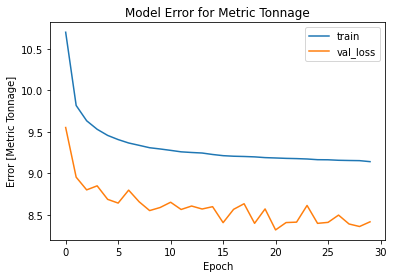

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train1920_baselineSC_batch16_30Epochs_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

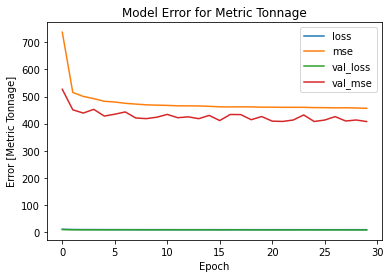

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train1920_baselineSC_batch16_30Epochs_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(4643649, 1)

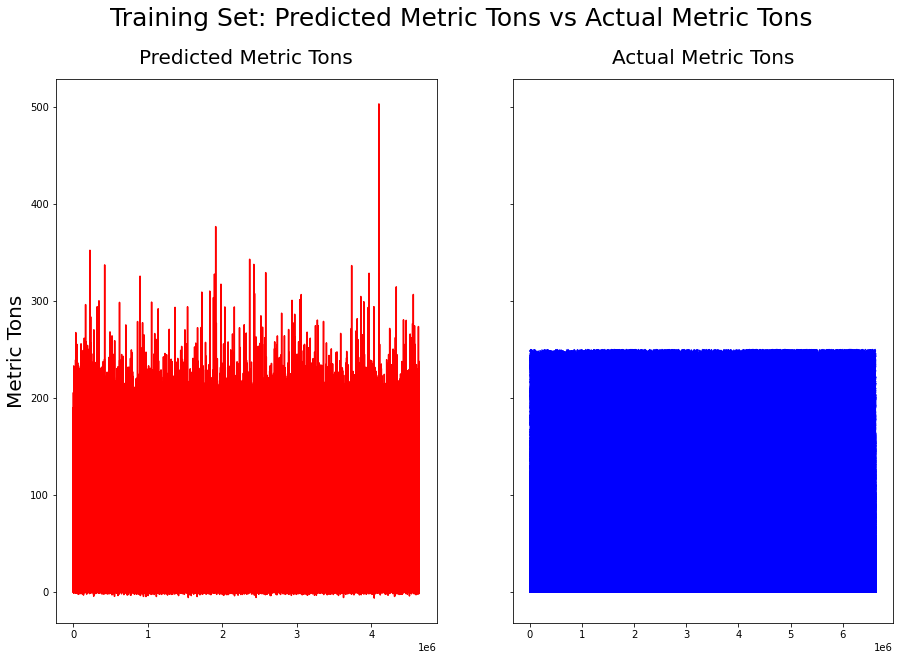

In [ ]:
# Graph predicted vs actual metric tonnage in the train set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch8_50Epochs_PredictedActual_Train_Side.png',
          dpi=my_dpi, bbox_inches='tight')

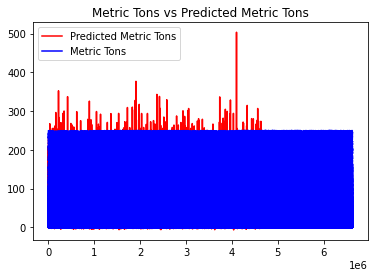

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the train set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch8_50Epochs_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(1990136, 1)

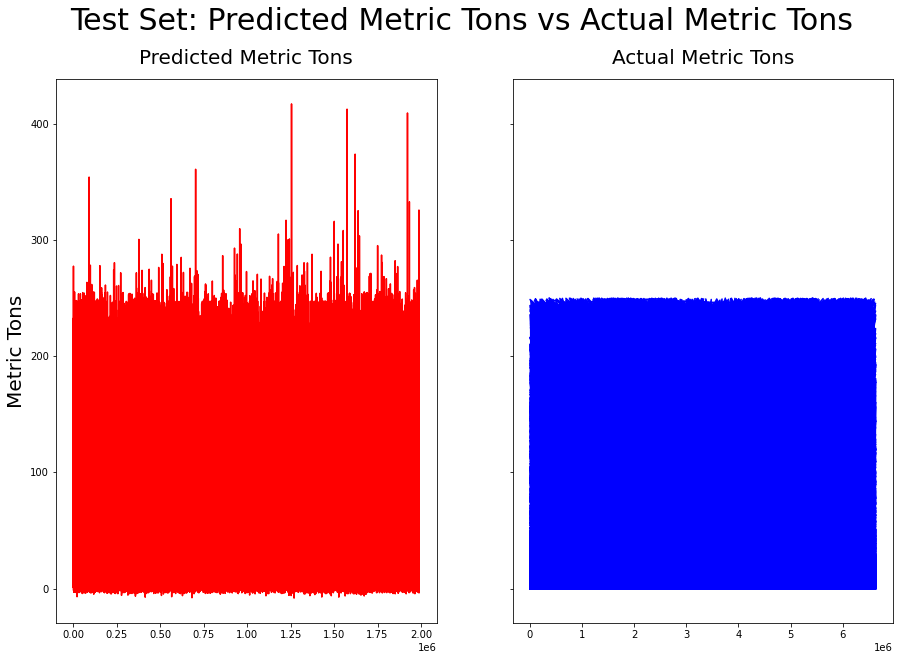

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch8_50Epochs_PredictedActual_Test_Side.png',
          dpi=my_dpi, bbox_inches='tight')

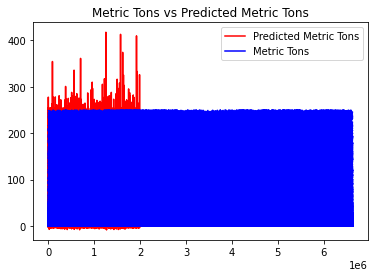

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch8_50Epochs_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f'% np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 8.384283
MSE: 404.857975
RMSE: 20.121083
R2: 0.584865


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 10.116713
MSE: 496.084394
RMSE: 22.272952
R2: 0.492027


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons', np.average(y_test))
print('Predicted Average Metric Tons', np.average(pred_test))
print('\nMinimum Metric Tons', np.amin(y_test))
print('Predicted Minimum Metric Tons', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 417.06778

Average Metric Tons 21.719979016509416
Predicted Average Metric Tons 20.538717

Minimum Metric Tons 0.0
Predicted Minimum Metric Tons -8.182351


## Train 2010-2019 Test 2020 Baseline Batch Size = 32

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()
        & df.State_Closure_EA_Diff.notna()]
df = df[df['Year'] < 2020]
print('Number of rows and columns:', df.shape)

Number of rows and columns: (29152058, 19)


In [ ]:
# X,y for encoding
X = df.drop(['Metric_Tons', 'DateTime'], axis=1)
y = df['Metric_Tons']

del df

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=X.Year,
                                                    random_state=1019)

del X, y

In [ ]:
# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_train.shape

(16893247, 34)

In [ ]:
# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Models/DL/MLP/Models

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

/content/drive/MyDrive/MaritimeTrade/Models/DL/MLP/Models
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train1019_baseline_sc_b32_epochs30.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  best_model_only=True, mode='min'),
                  tensorboard_callback]

In [ ]:
# Define Baseline model
model = Sequential()
model.add(Dense(30, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
model.compile(loss='mae', metrics=['mse'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1050      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
422332/422332 [==============================] - 935s 2ms/step - loss: 9.6943 - mse: 446.1781 - val_loss: 8.7496 - val_mse: 390.8900
Epoch 2/30
422332/422332 [==============================] - 959s 2ms/step - loss: 9.2162 - mse: 412.9214 - val_loss: 8.4212 - val_mse: 375.7799
Epoch 3/30
422332/422332 [==============================] - 917s 2ms/step - loss: 9.0297 - mse: 402.0034 - val_loss: 8.3467 - val_mse: 373.9240
Epoch 4/30
422332/422332 [==============================] - 920s 2ms/step - loss: 8.9537 - mse: 396.0067 - val_loss: 8.3418 - val_mse: 369.8779
Epoch 5/30
422332/422332 [==============================] - 929s 2ms/step - loss: 8.9054 - mse: 392.1855 - val_loss: 8.2432 - val_mse: 362.5407
Epoch 6/30
422332/422332 [==============================] - 921s 2ms/step - loss: 8.8783 - mse: 390.2737 - val_loss: 8.1926 - val_mse: 356.0669
Epoch 7/30
422332/422332 [==============================] - 918s 2ms/step - loss: 8.8597 - mse: 388.4507 - val_loss: 8.1190 - val_mse: 3

In [ ]:
# Save model
model.save('./MLP_Baseline_sc_batch32_30epochs_train1019_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train1019_baseline_sc_b32_epochs30.h5'
#model = tf.keras.models.load_model('./MLP_Baseline_sc_batch32_30epochs_train1019_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

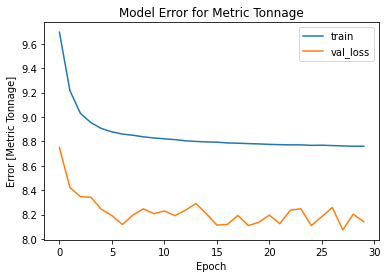

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train1019_baselineSC_batch32_30Epochs_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

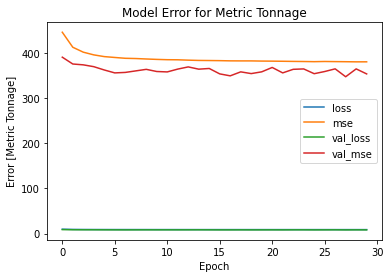

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train1019_baselineSC_batch32_30Epochs_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(16893247, 1)

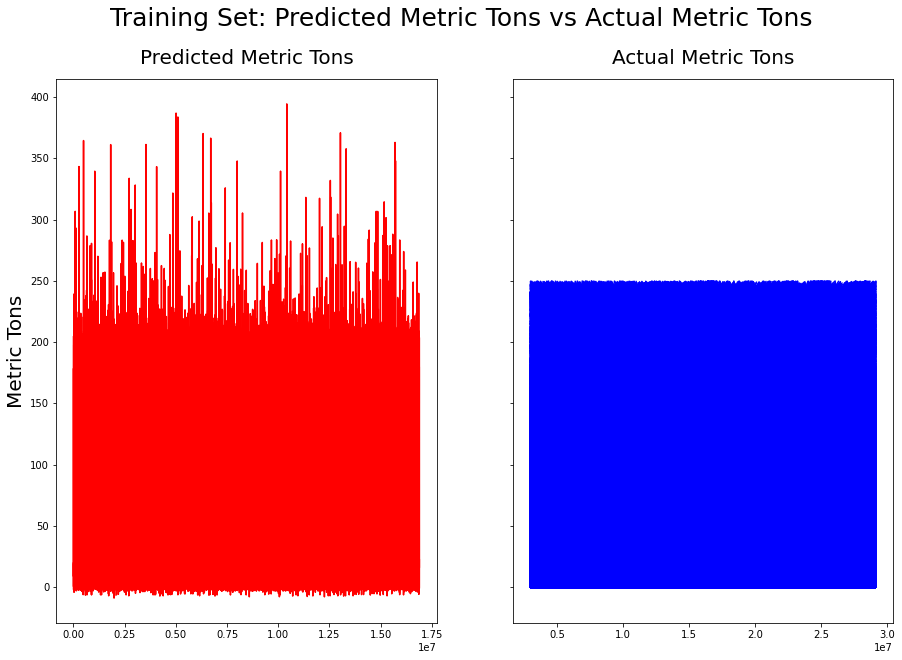

In [ ]:
# Graph predicted vs actual metric tonnage in the train set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

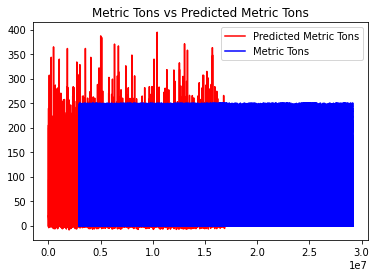

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the train set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(7239963, 1)

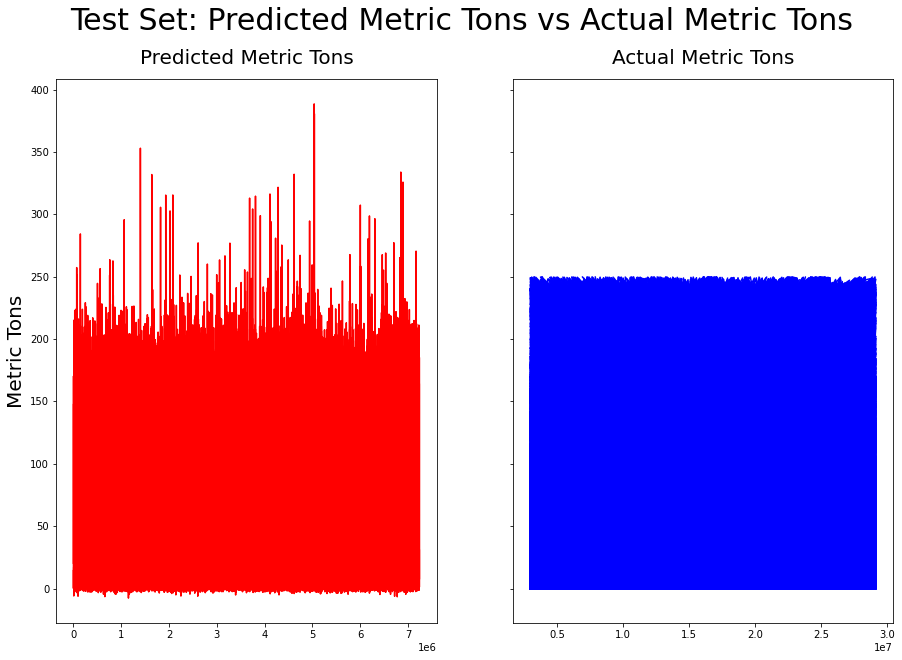

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

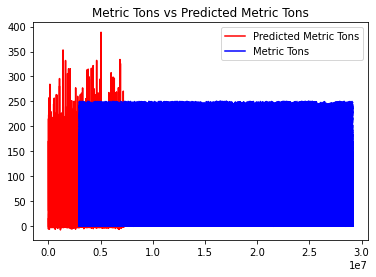

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1019_baselineSC_batch32_30Epochs_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f'% np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 8.127828
MSE: 352.190451
RMSE: 18.766738
R2: 0.503125


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 8.637050
MSE: 391.928194
RMSE: 19.797176
R2: 0.446796


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))

print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))

print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 388.61658

Average Metric Tons: 20.17341674121816
Predicted Average Metric Tons: 16.301502

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -7.649522


#### Test on 2020

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633785, 20)


In [ ]:
# Create year-week for stratification
df['DateTime']= pd.to_datetime(df['DateTime'])
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

df = df.drop(['DateTime'], axis=1)

In [ ]:
# Filter df to 2020
df = df[df['Year'] == 2020]

# Drop year variable
df = df.drop(['Year', 'DateTime_YearWeek'], axis=1)

In [ ]:
# Prepare 2020 for partitioning data
X = df.drop(['Metric_Tons'], axis=1)
y = df['Metric_Tons']

In [ ]:
# Process
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X = ce_ord.fit_transform(X)
X = pd.get_dummies(X, drop_first=True)
X = pd.DataFrame(sc.fit_transform(X))

In [ ]:
# Predict on test set
pred_test = model.predict(X)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(3265293, 1)

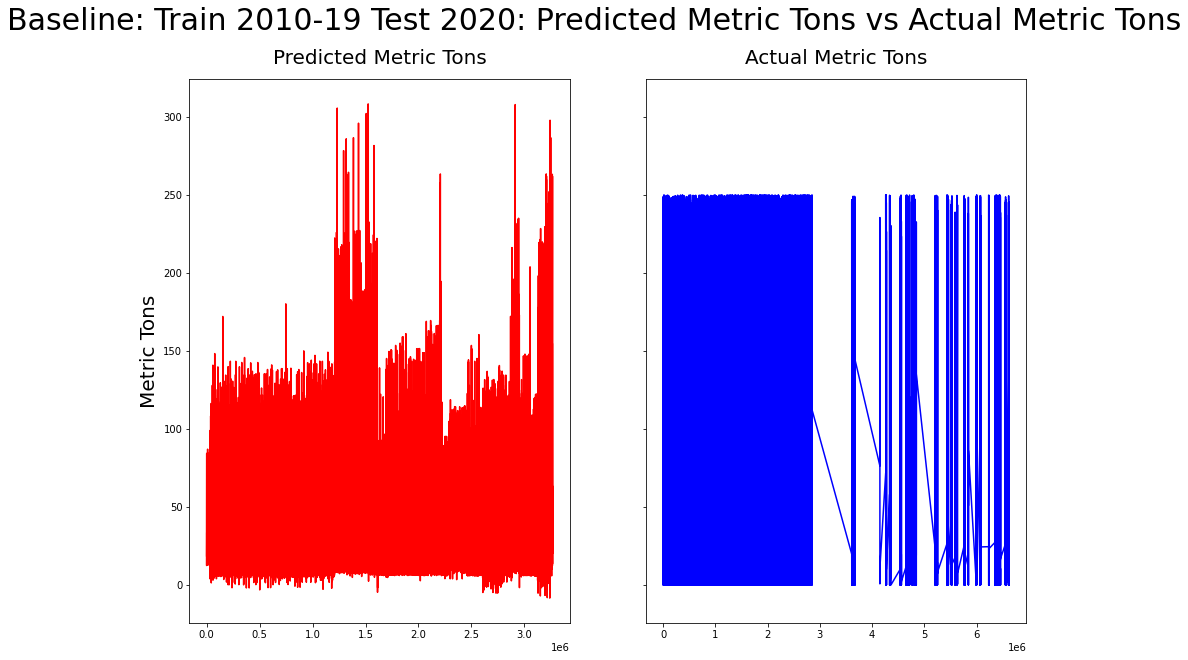

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Baseline: Train 2010-19 Test 2020: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train1019Test20_baselineSC_batch32_30Epochs_PredictedActual_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

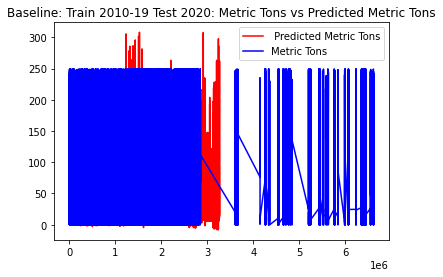

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Baseline: Train 2010-19 Test 2020: Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1019Test20_baselineSC_batch32_30Epochs_PredictedActual_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y[:], pred_test[:])))
print('R2: %3f' % r2_score(y[:], pred_test[:]))

Metrics: Test set
MAE: 23.538832
MSE: 1373.334543
RMSE: 37.058529
R2: -0.455251


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y))
print('\nMinimum Metric Tons:', np.amin(y))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.99
Predicted Max Metric Tons: 308.2283

Average Metric Tons: 21.53519470993873
Predicted Average Metric Tons: 29.537125

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -8.377576
